<a href="https://colab.research.google.com/github/vfrantc/deweather/blob/main/train_dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi 

Tue Jun 21 16:07:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
import shutil

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!git clone https://github.com/vfrantc/deweather.git

Cloning into 'deweather'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 76 (delta 15), reused 67 (delta 13), pack-reused 0
Unpacking objects: 100% (76/76), done.


In [5]:
%cd deweather/TransWeather-dehaze/

/content/deweather/TransWeather-dehaze


In [6]:
!cp /content/drive/MyDrive/haze/data/SOTS.zip .
!cp /content/drive/MyDrive/deweather2/reside.zip .
!unzip SOTS.zip
!unzip reside.zip 
!mkdir -p data/train/
!mkdir -p data/test/outdoor/
!cp -r hazy data/train/input 
!cp -r SOTS/outdoor/hazy data/test/outdoor/input

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: hazy/1822_0.8_0.08.jpg  
  inflating: hazy/1823_0.95_0.1.jpg  
  inflating: hazy/1828_0.9_0.08.jpg  
  inflating: hazy/1832_0.95_0.06.jpg  
  inflating: hazy/1875_0.8_0.06.jpg  
  inflating: hazy/1889_1_0.2.jpg     
  inflating: hazy/1911_0.9_0.06.jpg  
  inflating: hazy/1915_0.95_0.04.jpg  
  inflating: hazy/1971_0.85_0.2.jpg  
  inflating: hazy/1976_0.9_0.04.jpg  
  inflating: hazy/1977_0.9_0.2.jpg   
  inflating: hazy/1977_1_0.08.jpg    
  inflating: hazy/1979_0.85_0.12.jpg  
  inflating: hazy/1982_0.95_0.12.jpg  
  inflating: hazy/2000_0.85_0.12.jpg  
  inflating: hazy/2018_0.85_0.2.jpg  
  inflating: hazy/2020_0.9_0.1.jpg   
  inflating: hazy/2020_1_0.2.jpg     
  inflating: hazy/2026_0.9_0.04.jpg  
  inflating: hazy/2033_0.9_0.08.jpg  
  inflating: hazy/2033_0.95_0.08.jpg  
  inflating: hazy/2043_0.95_0.04.jpg  
  inflating: hazy/2060_0.8_0.04.jpg  
  inflating: hazy/2070_0.9_0.16.jpg  
  inflating: h

In [31]:
def process_dir(input_dir='data/train/input/', 
                gt_in='clear/', 
                gt_out='data/train/gt', 
                out_fname='data/train/reside.txt',
                preffix='input/'):
  if not os.path.exists(gt_out):
    os.makedirs(gt_out)
  
  with open(out_fname, 'w') as f:
    for fname in tqdm(glob(os.path.join(input_dir, '*.jpg'))):
      main_name = os.path.basename(fname)
      gt_name = main_name[:4] + '.jpg'
      try:
        shutil.copyfile(os.path.join(gt_in, gt_name), os.path.join(gt_out, main_name))
      except FileNotFoundError:
        img = cv2.imread(os.path.join(gt_in, gt_name).replace('.jpg', '.png'))
        cv2.imwrite(os.path.join(gt_out, main_name), img)
      f.write(preffix + main_name + '\n')

In [32]:
print('process train')
process_dir(input_dir='data/train/input/', gt_in='clear/', gt_out='data/train/gt', out_fname='data/train/reside.txt', preffix='input/')
print('process outdoor')
process_dir(input_dir='data/test/outdoor/input/', gt_in='SOTS/outdoor/gt/', gt_out='data/test/outdoor/gt/', out_fname='data/test/outdoor.txt', preffix='outdoor/input/')

process train


  0%|          | 0/72135 [00:00<?, ?it/s]

process outdoor


  0%|          | 0/500 [00:00<?, ?it/s]

# Train the same network for dehazing (for 10 epochs and see how it works)

In [45]:
%cd ..
!git pull
%cd TransWeather-dehaze/

/content/deweather
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/vfrantc/deweather
   19b5e07..d07b569  main       -> origin/main
Updating 19b5e07..d07b569
Fast-forward
 TransWeather-dehaze/train_data_functions.py | 6 +-----
 1 file changed, 1 insertion(+), 5 deletions(-)
/content/deweather/TransWeather-dehaze


In [ ]:
!python3 train.py  -train_batch_size 32 -exp_name Transweather -epoch_start 0 -num_epochs 10

Seed:	19
--- Hyper-parameters for training ---
learning_rate: 0.0002
crop_size: [256, 256]
train_batch_size: 32
val_batch_size: 1
lambda_loss: 0.04
--- no weight loaded ---
Rain Drop old_val_psnr: 53.75, old_val_ssim: 0.9625
Learning rate sets to 0.0002.
Epoch: 0, Iteration: 0
Epoch: 0, Iteration: 100
Epoch: 0, Iteration: 200
Epoch: 0, Iteration: 300
Epoch: 0, Iteration: 400
Epoch: 0, Iteration: 500
Epoch: 0, Iteration: 600


In [37]:

img = cv2.imread('data/train/gt/7871_0.8_0.2.jpg')
#!ls -la data/train/gt/7871_0.8_0.2.jpg

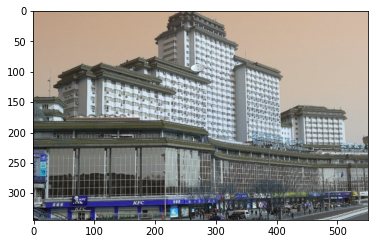

In [39]:
plt.imshow(img)

# Generate some images